# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [13]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
anio = 2026
name_file = 'anual' 
nombre_archivo = f'../data/data_forecast_{anio}/data_forecast_{anio}_silver/numero_membresia_{name_file}_limpio.csv'
print(f"Cargando el archivo: {nombre_archivo}")  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Cargando el archivo: ../data/data_forecast_2026/data_forecast_2026_silver/numero_membresia_anual_limpio.csv
Rango de fechas: 2022-07-28 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
0,1,521.0,2022-07-28,1.0
1,1,521.0,2022-07-29,1.0
2,1,521.0,2022-08-02,1.0
3,2,1042.0,2022-08-07,2.0
4,1,521.0,2022-08-10,1.0


In [14]:
df_main.describe()

,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
count,1213.000000,1213.000000,1213,1213.000000
mean,414.546579,220924.194897,2024-04-02 23:29:08.062654464,413.331410
min,1.000000,521.000000,2022-07-28 00:00:00,1.000000
25%,293.000000,152989.800000,2023-06-05 00:00:00,293.000000
50%,409.000000,220970.490000,2024-04-03 00:00:00,409.000000
75%,533.000000,284613.090000,2025-01-31 00:00:00,532.000000
max,904.000000,485895.090000,2025-11-30 00:00:00,854.000000
std,154.190660,83764.994675,NaN,152.280039


Filtro para obtener muestra de datos

In [15]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'cantidad_Vendida_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [16]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """
df['cap'] = 850

# 2. Configurar el modelo con crecimiento logístico
m = Prophet(
            changepoint_prior_scale=0.18,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
            seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
            daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
            #########
            growth='logistic', 
            seasonality_mode='multiplicative',
            yearly_seasonality=True)

m.add_country_holidays(country_name='MX')
m.fit(df)


17:18:30 - cmdstanpy - INFO - Chain [1] start processing
17:18:30 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [17]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365)
future['cap'] = 850

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds  cap
1573 2026-11-26  850
1574 2026-11-27  850
1575 2026-11-28  850
1576 2026-11-29  850
1577 2026-11-30  850


Paso 5: Realizar la Predicción (Forecast)

In [18]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds        yhat  yhat_lower  yhat_upper
1573 2026-11-26  461.130844  371.802919  542.308638
1574 2026-11-27  461.016653  376.931690  544.110842
1575 2026-11-28  493.131950  409.926222  578.382368
1576 2026-11-29  546.308335  458.190837  630.836025
1577 2026-11-30  470.254504  383.030633  566.172155


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

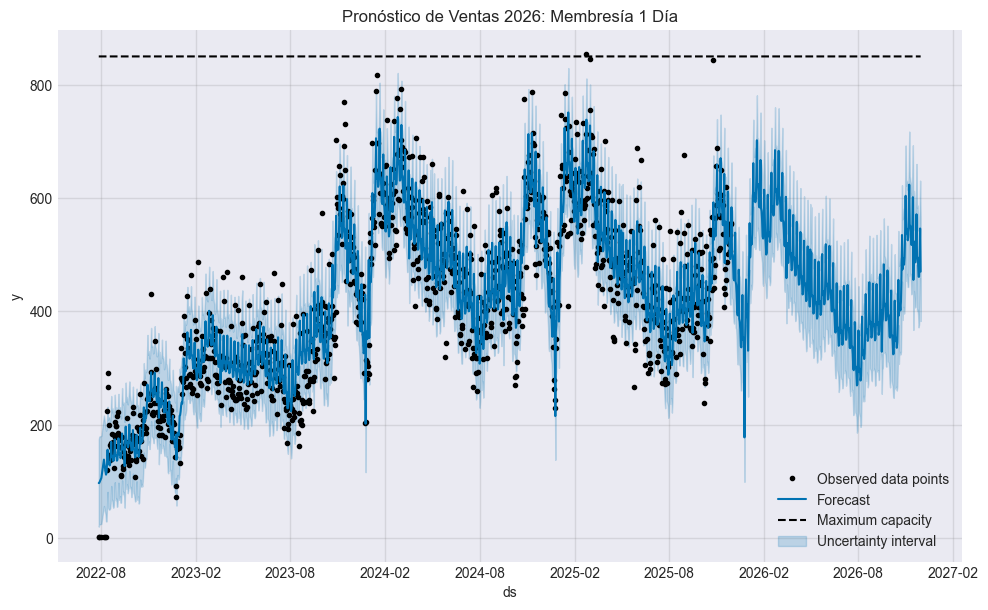

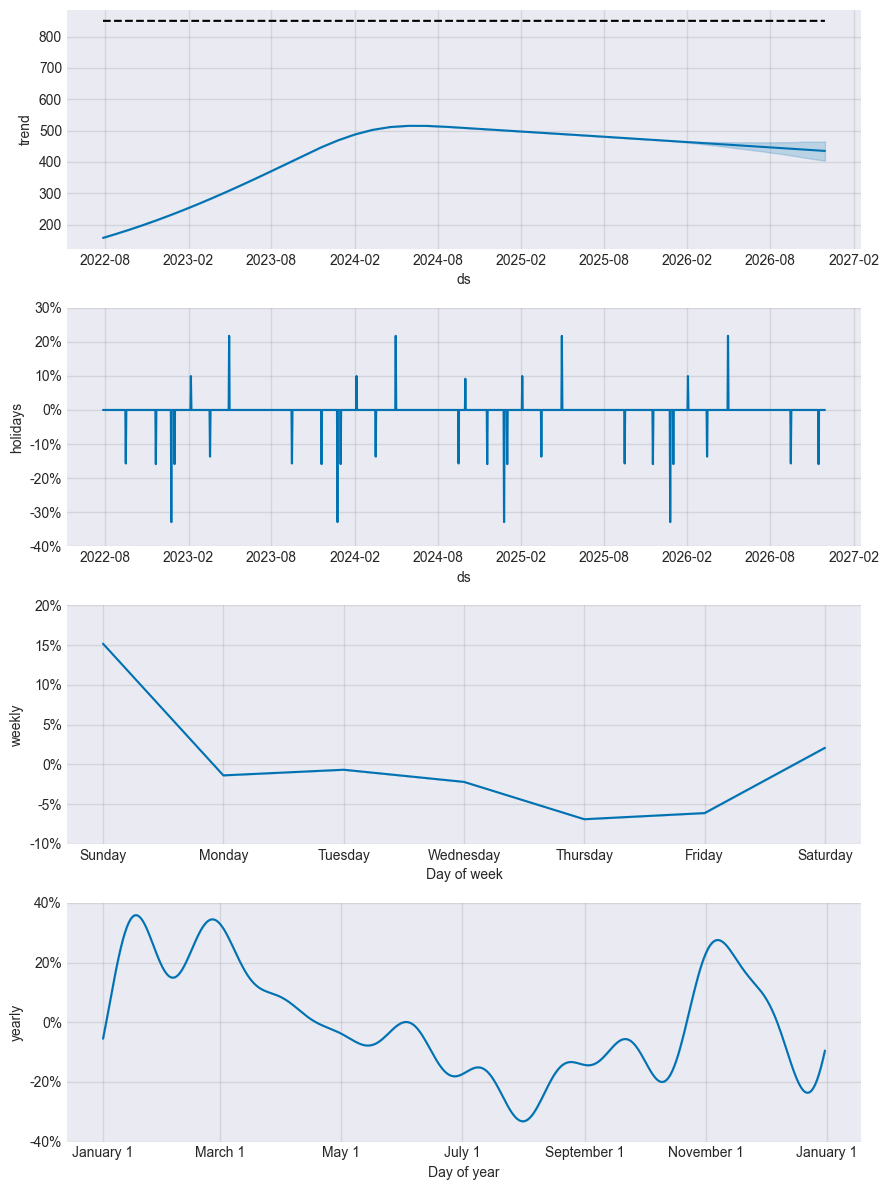

In [19]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas 2026: Membresía 1 Día")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [20]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(0).reset_index()
print(monthly_sales)

      month     yhat  yhat_lower  yhat_upper
0   2022-07    194.0        44.0       353.0
1   2022-08   3316.0      1414.0      5194.0
2   2022-09   4814.0      2457.0      7151.0
3   2022-10   5652.0      3182.0      8102.0
4   2022-11   7547.0      5167.0      9915.0
5   2022-12   6113.0      3674.0      8597.0
6   2023-01   9304.0      6843.0     11741.0
7   2023-02   9115.0      6927.0     11331.0
8   2023-03  10104.0      7692.0     12541.0
9   2023-04   9172.0      6809.0     11549.0
10  2023-05   9388.0      6930.0     11840.0
11  2023-06   9174.0      6829.0     11550.0
12  2023-07   8799.0      6352.0     11255.0
13  2023-08   9275.0      6806.0     11709.0
14  2023-09  10781.0      8435.0     13184.0
15  2023-10  12225.0      9782.0     14638.0
16  2023-11  15938.0     13579.0     18323.0
17  2023-12  12631.0     10187.0     15099.0
18  2024-01  18167.0     15741.0     20644.0
19  2024-02  17801.0     15502.0     20089.0
20  2024-03  18282.0     15812.0     20752.0
21  2024-0

In [21]:
monthly_sales.to_csv(f"../data/data_forecast_{anio}/data_forecast_{anio}_gold/forecast_numero_{name_file}_{anio}_monthly.csv")

In [22]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/3 [00:00<?, ?it/s]

17:18:34 - cmdstanpy - INFO - Chain [1] start processing
17:18:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]17:18:35 - cmdstanpy - INFO - Chain [1] start processing
17:18:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:01,  1.30s/it]17:18:36 - cmdstanpy - INFO - Chain [1] start processing
17:18:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

  horizon       rmse      mape
0  9 days  62.009215  0.098281
1 10 days  65.096630  0.106707
2 11 days  65.820031  0.109957
3 12 days  69.280856  0.122930
4 13 days  76.555901  0.140210
